1. Cargar y limpiar datos

In [12]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Cargar el dataset
file_path = './../data/linkedin_profiles_v9.csv'  # Cambia esto por la ruta correcta de tu archivo
df = pd.read_csv(file_path)

# Filtrar perfiles que tienen empleo actual en función de al menos uno de los dos campos
df['employed'] = df['current_company:company_id'].notna() | df['current_company:name'].notna()

# Contar el número de filas antes de eliminar
rows_before = df.shape[0]

# Eliminar filas donde 'experience' es nulo o vacío y hay empleo actual
df = df[~((df['experience'].isna() | (df['experience'].str.strip() == '')) & df['employed'])]

# Contar el número de filas después de eliminar
rows_after = df.shape[0]

# Calcular cuántas filas fueron eliminadas
rows_deleted = rows_before - rows_after

print(f"Número de filas eliminadas: {rows_deleted}")
print(f"Número de filas restantes: {rows_after}")

# Convertir la columna 'employed' a entero (1 si tiene empleo, 0 si no)
df['employed'] = df['employed'].astype(int)

Número de filas eliminadas: 3
Número de filas restantes: 997


In [13]:
# Total profiles in the dataset
total_profiles = len(df)

# Define unemployment condition based on specified fields
unemployed_condition = (
    (df['current_company:company_id'].isna() | (df['current_company:company_id'] == '')) &
    (df['current_company:name'].isna() | (df['current_company:name'] == ''))
)

# Calculate number of employed and unemployed profiles
unemployed = df[unemployed_condition].shape[0]
employed = total_profiles - unemployed

# Calculate percentages
percentage_employed = (employed / total_profiles) * 100
percentage_unemployed = (unemployed / total_profiles) * 100

# Calculate education and certifications count
df['education_count'] = df['education'].apply(lambda x: len(eval(x)) if pd.notnull(x) and x.startswith('[') else 0)
df['certifications_count'] = df['certifications'].apply(lambda x: len(eval(x)) if pd.notnull(x) and x.startswith('[') else 0)

# Profiles with educational details
profiles_with_education = df['education_count'].gt(0).sum()
percentage_with_education = (profiles_with_education / total_profiles) * 100

# Profiles with certifications
profiles_with_certifications = df['certifications_count'].gt(0).sum()
percentage_with_certifications = (profiles_with_certifications / total_profiles) * 100

# Display the results
print(f"Employed: {employed} ({percentage_employed:.2f}%)")
print(f"Unemployed: {unemployed} ({percentage_unemployed:.2f}%)")
print(f"Profiles with Education: {profiles_with_education} ({percentage_with_education:.2f}%)")
print(f"Profiles with Certifications: {profiles_with_certifications} ({percentage_with_certifications:.2f}%)")

Employed: 830 (83.25%)
Unemployed: 167 (16.75%)
Profiles with Education: 720 (72.22%)
Profiles with Certifications: 184 (18.46%)


2. Extracción de características

In [14]:
from datetime import datetime
from dateutil import parser
import json

def count_entries(column):
    try:
        return len(eval(column)) if pd.notnull(column) and column.startswith('[') else 0
    except:
        return 0

# Aplicar funciones de extracción
df['education_count'] = df['education'].apply(count_entries)
df['certifications_count'] = df['certifications'].apply(count_entries)
df['languages_count'] = df['languages'].apply(count_entries)
df['volunteer_experience_count'] = df['volunteer_experience'].apply(count_entries)
df['courses_count'] = df['сourses'].apply(count_entries)

# Lista de términos que representan la actualidad en varios idiomas
terms_for_present = [
    'present', 'actualidad', 'aujourd’hui', 'heden', 'nu', 'momento', 'heute',
    'obecnie', 'kasalukuyan', 'o momento', 'aujourd’hui', 'heden', 'oggi', 
    'today', 'aktuell', 'heden', 'aujourd’hui', 'nu', 'nu', 'nu', 'aujourd’hui'
]

# Función para convertir fechas a un formato estandarizado
def parse_date(date_str):
    if not date_str or any(term in date_str.lower() for term in terms_for_present):
        return datetime.now()  # Tratar términos de actualidad como la fecha actual

    # Intentar con diferentes formatos manualmente si parser no funciona
    date_formats = [
        '%b %Y',  # Ejemplo: Jan 2020
        '%Y',     # Ejemplo: 2020
    ]

    # Tratar de parsear usando diferentes formatos
    for fmt in date_formats:
        try:
            return datetime.strptime(date_str, fmt)
        except ValueError:
            continue

    # Tratar con parser si los formatos anteriores fallan
    try:
        return parser.parse(date_str, default=datetime(1, 1, 1), fuzzy=True)
    except (ValueError, TypeError):
        print(f"Error al parsear la fecha '{date_str}': Unknown string format")
        return None

# Función mejorada para calcular años de experiencia evitando la superposición de fechas
def extract_experience_years_from_json(experience):
    try:
        periods = []
        experience_data = json.loads(experience)

        for job in experience_data:
            positions = job.get('positions', [job])  # Si no hay posiciones, usar el trabajo mismo
            for position in positions:
                start_date_str = position.get('start_date', None)
                end_date_str = position.get('end_date', None)

                start_date = parse_date(start_date_str)
                end_date = parse_date(end_date_str) if end_date_str else datetime.now()

                if start_date and end_date:
                    periods.append((start_date, end_date))

        if not periods:
            return 0

        # Consolidar períodos para evitar la superposición
        periods = sorted(periods, key=lambda x: x[0])
        consolidated_periods = []
        current_start, current_end = periods[0]

        for start, end in periods[1:]:
            if start <= current_end:  # Si los períodos se solapan, extender el período actual
                current_end = max(current_end, end)
            else:  # Si no se solapan, añadir el período consolidado y empezar un nuevo período
                consolidated_periods.append((current_start, current_end))
                current_start, current_end = start, end

        consolidated_periods.append((current_start, current_end))  # Añadir el último período

        # Calcular la experiencia total en años y meses
        total_months = sum((end.year - start.year) * 12 + (end.month - start.month) for start, end in consolidated_periods)
        total_years = total_months // 12
        return total_years

    except Exception as e:
        print(f"Error procesando la experiencia: {e}")
        return 0

# Aplicar la función mejorada de experiencia
df['experience_years'] = df['experience'].apply(lambda x: extract_experience_years_from_json(x) if isinstance(x, str) else 0)
df

,timestamp,id,name,city,country_code,region,current_company:company_id,current_company:name,position,following,...,recommendations_count,volunteer_experience,сourses,employed,education_count,certifications_count,languages_count,volunteer_experience_count,courses_count,experience_years
0,2023-01-10,catherinemcilkenny,"Catherine Fitzpatrick (McIlkenny), B.A",Canada,CA,NaN,NaN,NaN,Snr Business Analyst at Emploi et Développemen...,NaN,...,NaN,NaN,NaN,0,5,0,0,0,0,0
1,2022-12-17,margot-bon-51a04624,Margot Bon,"The Randstad, Netherlands",NL,EU,gemeente-utrecht,Gemeente Utrecht,Communicatieadviseur Corporate & Strategie Gem...,NaN,...,2.0,"[{""cause"":"""",""duration"":""Sep 2010 Jul 2020 9 y...",NaN,1,6,1,4,3,0,28
2,2023-05-17,mike-dean-8509a193,Mike Dean,"England, United Kingdom",UK,NaN,network-rail,Network Rail,Network Data Manager at Network Rail,NaN,...,NaN,NaN,NaN,1,1,0,0,0,0,32
3,2022-05-29,giovanna-panarella-99a0a4167,Giovanna Panarella,"Avellino, Campania, Italy",IT,EU,NaN,Freelance,Architetto (Freelance),500.0,...,NaN,"[{""cause"":""Arts and Culture"",""duration"":""Jan 2...",NaN,1,5,0,0,1,0,6
4,2022-12-06,steve-latimer-3364327,Steve Latimer,"Ontario, Canada",CA,NaN,mid-range-computer-group-inc.,Mid-Range Computer Group Inc.,Senior Account Executive at Mid-Range Computer...,NaN,...,1.0,NaN,NaN,1,2,43,0,0,0,31
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,2022-03-29,lore-geduhn-58978171,Lore Geduhn,"Hagen, North Rhine-Westphalia, Germany",DE,EU,NaN,Awwads Lernzirkel,Bürokraft bei Awwads Lernzirkel,1.0,...,NaN,NaN,NaN,1,0,0,0,0,0,0
996,2022-01-23,aaron-rodzinak-6005403,Aaron Rodzinak,"Boulder, Colorado, United States",US,NaN,ball-aerospace,Ball Aerospace,"Principal Spacecraft Systems Engineer, Ball Ae...",397.0,...,NaN,NaN,NaN,1,1,0,0,0,0,33
997,2021-04-30,carmen-nemoianu-a2130869,carmen nemoianu,Romania,RO,AS,NaN,NaN,medic,29.0,...,NaN,NaN,NaN,0,1,0,0,0,0,0
998,2022-02-09,carlos-soriano-51022049,Carlos Soriano,Greater Houston,US,NaN,NaN,NaN,Seeking,457.0,...,NaN,NaN,NaN,0,1,0,2,0,0,14


3. Preparación de Datos para Entrenamiento

In [15]:
# Preparar las características y etiquetas
features = ['education_count', 'certifications_count', 'languages_count', 
            'volunteer_experience_count', 'courses_count', 'experience_years']
X = df[features].fillna(0)
y = df['employed']

# Dividir en entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Normalizar características
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

4. Entrenamiento y Evaluación de Múltiples Modelos (XGBoost)

In [16]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from xgboost import XGBClassifier
from imblearn.over_sampling import SMOTE
import numpy as np

# Aplicar SMOTE para balancear las clases en el conjunto de entrenamiento
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train_scaled, y_train)

# Configurar los modelos y parámetros para GridSearch
param_grid_xgb = {
    'n_estimators': [100, 200, 300],
    'max_depth': [5, 10, 15],
    'learning_rate': [0.01, 0.1, 0.2],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0]
}

grid_search_xgb = GridSearchCV(
    estimator=XGBClassifier(random_state=42),
    param_grid=param_grid_xgb,
    scoring='f1_weighted',
    cv=5,
    verbose=1,
    n_jobs=-1
)

# Ejecutar el Grid Search
grid_search_xgb.fit(X_train_resampled, y_train_resampled)
print(f"Mejores parámetros para XGBoost: {grid_search_xgb.best_params_}")

# Evaluar el modelo optimizado con StratifiedKFold
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Crear el modelo XGBoost con los mejores hiperparámetros
xgb_model = XGBClassifier(**grid_search_xgb.best_params_, random_state=42)

# Convertir y_train a numpy array para evitar problemas de indexación
y_train_array = np.array(y_train)

# Inicializar listas para almacenar las métricas de cada pliegue
precision_scores = {'0': [], '1': [], 'weighted': []}
recall_scores = {'0': [], '1': [], 'weighted': []}
f1_scores = {'0': [], '1': [], 'weighted': []}
confusion_matrices = []

# Realizar la validación cruzada estratificada
for train_index, test_index in skf.split(X_train_scaled, y_train_array):
    # Dividir los datos en entrenamiento y validación para cada pliegue
    X_fold_train, X_fold_val = X_train_scaled[train_index], X_train_scaled[test_index]
    y_fold_train, y_fold_val = y_train_array[train_index], y_train_array[test_index]

    # Aplicar SMOTE en cada fold para balancear las clases
    X_fold_resampled, y_fold_resampled = smote.fit_resample(X_fold_train, y_fold_train)

    # Entrenar el modelo en el pliegue actual
    xgb_model.fit(X_fold_resampled, y_fold_resampled)
    y_fold_pred = xgb_model.predict(X_fold_val)

    # Calcular métricas de rendimiento
    report = classification_report(y_fold_val, y_fold_pred, output_dict=True)
    
    # Guardar métricas para cada clase y promedio ponderado
    precision_scores['0'].append(report['0']['precision'])
    precision_scores['1'].append(report['1']['precision'])
    precision_scores['weighted'].append(report['weighted avg']['precision'])
    
    recall_scores['0'].append(report['0']['recall'])
    recall_scores['1'].append(report['1']['recall'])
    recall_scores['weighted'].append(report['weighted avg']['recall'])
    
    f1_scores['0'].append(report['0']['f1-score'])
    f1_scores['1'].append(report['1']['f1-score'])
    f1_scores['weighted'].append(report['weighted avg']['f1-score'])
    
    confusion_matrices.append(confusion_matrix(y_fold_val, y_fold_pred))

# Mostrar los resultados promediados de todos los pliegues
print(f"Precision promedio para clase 0: {np.mean(precision_scores['0']):.4f}")
print(f"Precision promedio para clase 1: {np.mean(precision_scores['1']):.4f}")
print(f"Precision promedio ponderado: {np.mean(precision_scores['weighted']):.4f}")

print(f"Recall promedio para clase 0: {np.mean(recall_scores['0']):.4f}")
print(f"Recall promedio para clase 1: {np.mean(recall_scores['1']):.4f}")
print(f"Recall promedio ponderado: {np.mean(recall_scores['weighted']):.4f}")

print(f"F1-Score promedio para clase 0: {np.mean(f1_scores['0']):.4f}")
print(f"F1-Score promedio para clase 1: {np.mean(f1_scores['1']):.4f}")
print(f"F1-Score promedio ponderado: {np.mean(f1_scores['weighted']):.4f}")

# Mostrar la matriz de confusión promediada
mean_confusion_matrix = np.mean(confusion_matrices, axis=0)
print("Matriz de Confusión Promediada:")
print(mean_confusion_matrix)

Fitting 5 folds for each of 243 candidates, totalling 1215 fits
Mejores parámetros para XGBoost: {'colsample_bytree': 1.0, 'learning_rate': 0.2, 'max_depth': 5, 'n_estimators': 300, 'subsample': 0.6}
Precision promedio para clase 0: 0.4507
Precision promedio para clase 1: 0.9166
Precision promedio ponderado: 0.8331
Recall promedio para clase 0: 0.6560
Recall promedio para clase 1: 0.8234
Recall promedio ponderado: 0.7934
F1-Score promedio para clase 0: 0.5327
F1-Score promedio para clase 1: 0.8672
F1-Score promedio ponderado: 0.8072
Matriz de Confusión Promediada:
[[16.4  8.6]
 [20.2 94.2]]


5. Predicción de Candidatos Potenciales (XGBoost)

In [17]:
# Usar el modelo optimizado para predecir candidatos potenciales sin empleo
unemployed_profiles = df[df['employed'] == 0].copy()
unemployed_features = unemployed_profiles[features].fillna(0)
unemployed_features_scaled = scaler.transform(unemployed_features)

unemployed_profiles['predicted_employed'] = xgb_model.predict(unemployed_features_scaled)

potential_candidates = unemployed_profiles[unemployed_profiles['predicted_employed'] == 1]
potential_candidates.to_csv('./../data/potential_candidates_xgboost.csv', index=False)
print("Candidatos potenciales guardados en 'potential_candidates_optimized.csv'")

Candidatos potenciales guardados en 'potential_candidates_optimized.csv'


Optimización y mejora de XGBoost

In [18]:
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.metrics import classification_report, confusion_matrix
from imblearn.over_sampling import BorderlineSMOTE
import numpy as np

# Aplicar Borderline-SMOTE para balancear las clases en el conjunto de entrenamiento
smote = BorderlineSMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train_scaled, y_train)

# Definir los parámetros para GridSearch con ajustes adicionales de regularización
param_grid_xgb = {
    'n_estimators': [400, 500, 600],
    'max_depth': [6, 10, 15],
    'learning_rate': [0.1, 0.2, 0.3],
    'subsample': [0.6, 0.8],
    'colsample_bytree': [0.8, 1.0],
    'scale_pos_weight': [1.5, 2, 2.5],  # Ajuste del peso de la clase 0
    'gamma': [0.5, 1, 1.5],
    'min_child_weight': [1, 5, 10],
    'reg_alpha': [0.5, 1, 1.5],  # Regularización L1
    'reg_lambda': [1, 1.5, 2]    # Regularización L2
}

grid_search_xgb = GridSearchCV(
    estimator=XGBClassifier(random_state=42, objective='binary:logistic', eval_metric='aucpr'),
    param_grid=param_grid_xgb,
    scoring='f1_weighted',
    cv=5,
    verbose=1,
    n_jobs=-1
)

# Ejecutar el Grid Search
grid_search_xgb.fit(X_train_resampled, y_train_resampled)
print(f"Mejores parámetros para XGBoost: {grid_search_xgb.best_params_}")

# Evaluar el modelo optimizado con StratifiedKFold
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
xgb_params = grid_search_xgb.best_params_
xgb_params.update({'objective': 'binary:logistic', 'eval_metric': 'aucpr', 'random_state': 42})

# Inicializar listas para almacenar las métricas de cada pliegue
precision_scores = {'0': [], '1': [], 'weighted': []}
recall_scores = {'0': [], '1': [], 'weighted': []}
f1_scores = {'0': [], '1': [], 'weighted': []}
confusion_matrices = []

# Realizar la validación cruzada estratificada
for train_index, test_index in skf.split(X_train_scaled, y_train_array):
    X_fold_train, X_fold_val = X_train_scaled[train_index], X_train_scaled[test_index]
    y_fold_train, y_fold_val = y_train_array[train_index], y_train_array[test_index]

    X_fold_resampled, y_fold_resampled = smote.fit_resample(X_fold_train, y_fold_train)
    xgb_model = XGBClassifier(**xgb_params)
    xgb_model.fit(X_fold_resampled, y_fold_resampled)
    
    y_fold_pred = xgb_model.predict(X_fold_val)
    report = classification_report(y_fold_val, y_fold_pred, output_dict=True)
    
    precision_scores['0'].append(report['0']['precision'])
    precision_scores['1'].append(report['1']['precision'])
    precision_scores['weighted'].append(report['weighted avg']['precision'])
    
    recall_scores['0'].append(report['0']['recall'])
    recall_scores['1'].append(report['1']['recall'])
    recall_scores['weighted'].append(report['weighted avg']['recall'])
    
    f1_scores['0'].append(report['0']['f1-score'])
    f1_scores['1'].append(report['1']['f1-score'])
    f1_scores['weighted'].append(report['weighted avg']['f1-score'])
    
    confusion_matrices.append(confusion_matrix(y_fold_val, y_fold_pred))

# Mostrar los resultados promediados de todos los pliegues
print(f"Precision promedio para clase 0: {np.mean(precision_scores['0']):.4f}")
print(f"Precision promedio para clase 1: {np.mean(precision_scores['1']):.4f}")
print(f"Precision promedio ponderado: {np.mean(precision_scores['weighted']):.4f}")

print(f"Recall promedio para clase 0: {np.mean(recall_scores['0']):.4f}")
print(f"Recall promedio para clase 1: {np.mean(recall_scores['1']):.4f}")
print(f"Recall promedio ponderado: {np.mean(recall_scores['weighted']):.4f}")

print(f"F1-Score promedio para clase 0: {np.mean(f1_scores['0']):.4f}")
print(f"F1-Score promedio para clase 1: {np.mean(f1_scores['1']):.4f}")
print(f"F1-Score promedio ponderado: {np.mean(f1_scores['weighted']):.4f}")

mean_confusion_matrix = np.mean(confusion_matrices, axis=0)
print("Matriz de Confusión Promediada:")
print(mean_confusion_matrix)

Fitting 5 folds for each of 26244 candidates, totalling 131220 fits


c:\Users\pascu\Desktop\MÁSTER INTELIGENCIA ARTIFICIAL\TFM\Talent-Analyzer-AI\.venv\Lib\site-packages\numpy\ma\core.py:2881: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


Mejores parámetros para XGBoost: {'colsample_bytree': 1.0, 'gamma': 1, 'learning_rate': 0.3, 'max_depth': 10, 'min_child_weight': 1, 'n_estimators': 600, 'reg_alpha': 1, 'reg_lambda': 1.5, 'scale_pos_weight': 1.5, 'subsample': 0.6}
Precision promedio para clase 0: 0.4642
Precision promedio para clase 1: 0.9206
Precision promedio ponderado: 0.8387
Recall promedio para clase 0: 0.6720
Recall promedio para clase 1: 0.8287
Recall promedio ponderado: 0.8006
F1-Score promedio para clase 0: 0.5476
F1-Score promedio para clase 1: 0.8719
F1-Score promedio ponderado: 0.8138
Matriz de Confusión Promediada:
[[16.8  8.2]
 [19.6 94.8]]


In [19]:
# Filtrar perfiles sin empleo
unemployed_profiles_xgb = df[df['employed'] == 0].copy()
unemployed_features_xgb = unemployed_profiles_xgb[features].fillna(0)
unemployed_features_scaled_xgb = scaler.transform(unemployed_features_xgb)

# Predecir candidatos potenciales con el modelo optimizado de XGBoost
unemployed_profiles_xgb['predicted_employed'] = xgb_model.predict(unemployed_features_scaled_xgb)

# Filtrar perfiles que son candidatos potenciales (predicción = 1)
potential_candidates_xgb = unemployed_profiles_xgb[unemployed_profiles_xgb['predicted_employed'] == 1]

# Guardar los candidatos potenciales en un archivo CSV
potential_candidates_xgb.to_csv('./../data/potential_candidates_xgboost_optimized.csv', index=False)
print("Candidatos potenciales guardados en './../data/potential_candidates_xgboost_optimized.csv'")

Candidatos potenciales guardados en './../data/potential_candidates_xgboost_optimized.csv'


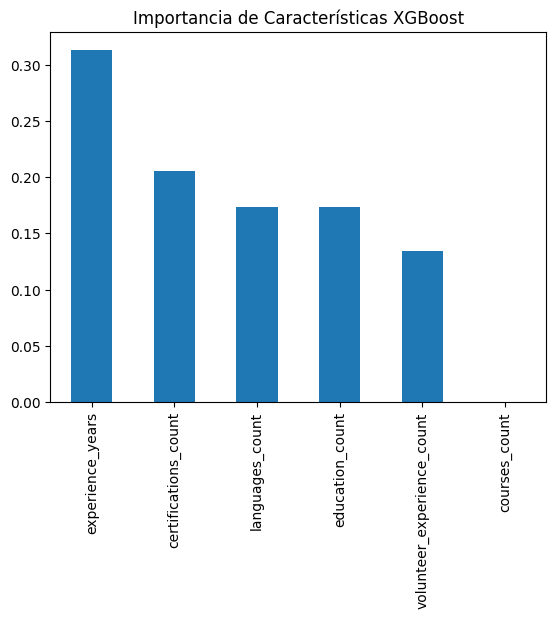

Importancias de características guardadas en './data/feature_importances_xgboost.csv'


In [20]:
import pandas as pd
import matplotlib.pyplot as plt

# Entrenar el modelo XGBoost optimizado con los datos resampleados (por si aún no está entrenado)
xgb_model.fit(X_train_resampled, y_train_resampled)

# Extraer la importancia de las características usando el modelo XGBoost optimizado
feature_importances_xgb = pd.Series(xgb_model.feature_importances_, index=features)

# Ordenar las importancias en orden descendente
feature_importances_xgb_sorted = feature_importances_xgb.sort_values(ascending=False)

# Visualizar las importancias
feature_importances_xgb_sorted.plot(kind='bar', title='Importancia de Características XGBoost')
plt.show()

# Guardar las importancias en un archivo CSV para usar en la aplicación Streamlit
feature_importances_xgb_df = pd.DataFrame({
    'feature': feature_importances_xgb_sorted.index,
    'importance': feature_importances_xgb_sorted.values
})

# Guarda el DataFrame de importancias en un CSV
feature_importances_xgb_df.to_csv('./../data/feature_importances_xgboost.csv', index=False)

print("Importancias de características guardadas en './data/feature_importances_xgboost.csv'")

# Seleccionar las características más importantes (por encima de un umbral, por ejemplo 0.05)
important_features_xgb = feature_importances_xgb[feature_importances_xgb > 0.05].index.tolist()
X_train_important_xgb = X_train[important_features_xgb]
X_test_important_xgb = X_test[important_features_xgb]

4.1 Entrenamiento y evaluación de modelos (Random Forest)

In [21]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from imblearn.over_sampling import SMOTE
import numpy as np

# Aplicar SMOTE para balancear las clases en el conjunto de entrenamiento
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train_scaled, y_train)

# Configurar los parámetros para GridSearch de Random Forest
param_grid_rf = {
    'n_estimators': [100, 200, 300],
    'max_depth': [5, 10, 15],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2']
}

# Configurar GridSearchCV
grid_search_rf = GridSearchCV(
    estimator=RandomForestClassifier(random_state=42),
    param_grid=param_grid_rf,
    scoring='f1_weighted',
    cv=5,
    verbose=1,
    n_jobs=-1
)

# Ejecutar el Grid Search
grid_search_rf.fit(X_train_resampled, y_train_resampled)
print(f"Mejores parámetros para Random Forest: {grid_search_rf.best_params_}")

# Crear el modelo de Random Forest con los mejores hiperparámetros
best_params_rf = grid_search_rf.best_params_
rf_model = RandomForestClassifier(**best_params_rf, random_state=42)

# Evaluar el modelo optimizado con StratifiedKFold
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Inicializar listas para almacenar las métricas de cada pliegue
precision_scores_rf = {'0': [], '1': [], 'weighted': []}
recall_scores_rf = {'0': [], '1': [], 'weighted': []}
f1_scores_rf = {'0': [], '1': [], 'weighted': []}
confusion_matrices_rf = []

# Realizar la validación cruzada estratificada
for train_index, test_index in skf.split(X_train_scaled, y_train_array):
    # Dividir los datos en entrenamiento y validación para cada pliegue
    X_fold_train, X_fold_val = X_train_scaled[train_index], X_train_scaled[test_index]
    y_fold_train, y_fold_val = y_train_array[train_index], y_train_array[test_index]

    # Aplicar SMOTE en cada fold para balancear las clases
    X_fold_resampled, y_fold_resampled = smote.fit_resample(X_fold_train, y_fold_train)

    # Entrenar el modelo en el pliegue actual
    rf_model.fit(X_fold_resampled, y_fold_resampled)
    y_fold_pred = rf_model.predict(X_fold_val)

    # Calcular métricas de rendimiento
    report = classification_report(y_fold_val, y_fold_pred, output_dict=True)
    
    # Guardar métricas para cada clase y promedio ponderado
    precision_scores_rf['0'].append(report['0']['precision'])
    precision_scores_rf['1'].append(report['1']['precision'])
    precision_scores_rf['weighted'].append(report['weighted avg']['precision'])
    
    recall_scores_rf['0'].append(report['0']['recall'])
    recall_scores_rf['1'].append(report['1']['recall'])
    recall_scores_rf['weighted'].append(report['weighted avg']['recall'])
    
    f1_scores_rf['0'].append(report['0']['f1-score'])
    f1_scores_rf['1'].append(report['1']['f1-score'])
    f1_scores_rf['weighted'].append(report['weighted avg']['f1-score'])
    
    confusion_matrices_rf.append(confusion_matrix(y_fold_val, y_fold_pred))

# Mostrar los resultados promediados de todos los pliegues
print(f"Precision promedio para clase 0 (Random Forest): {np.mean(precision_scores_rf['0']):.4f}")
print(f"Precision promedio para clase 1 (Random Forest): {np.mean(precision_scores_rf['1']):.4f}")
print(f"Precision promedio ponderado (Random Forest): {np.mean(precision_scores_rf['weighted']):.4f}")

print(f"Recall promedio para clase 0 (Random Forest): {np.mean(recall_scores_rf['0']):.4f}")
print(f"Recall promedio para clase 1 (Random Forest): {np.mean(recall_scores_rf['1']):.4f}")
print(f"Recall promedio ponderado (Random Forest): {np.mean(recall_scores_rf['weighted']):.4f}")

print(f"F1-Score promedio para clase 0 (Random Forest): {np.mean(f1_scores_rf['0']):.4f}")
print(f"F1-Score promedio para clase 1 (Random Forest): {np.mean(f1_scores_rf['1']):.4f}")
print(f"F1-Score promedio ponderado (Random Forest): {np.mean(f1_scores_rf['weighted']):.4f}")

# Mostrar la matriz de confusión promediada
mean_confusion_matrix_rf = np.mean(confusion_matrices_rf, axis=0)
print("Matriz de Confusión Promediada (Random Forest):")
print(mean_confusion_matrix_rf)

Fitting 5 folds for each of 162 candidates, totalling 810 fits
Mejores parámetros para Random Forest: {'max_depth': 15, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 200}
Precision promedio para clase 0 (Random Forest): 0.4569
Precision promedio para clase 1 (Random Forest): 0.9253
Precision promedio ponderado (Random Forest): 0.8413
Recall promedio para clase 0 (Random Forest): 0.6960
Recall promedio para clase 1 (Random Forest): 0.8182
Recall promedio ponderado (Random Forest): 0.7963
F1-Score promedio para clase 0 (Random Forest): 0.5501
F1-Score promedio para clase 1 (Random Forest): 0.8681
F1-Score promedio ponderado (Random Forest): 0.8111
Matriz de Confusión Promediada (Random Forest):
[[17.4  7.6]
 [20.8 93.6]]


5. Predicción de Candidatos Potenciales (Random Forest)

In [22]:
# Filtrar perfiles sin empleo
unemployed_profiles_rf = df[df['employed'] == 0].copy()
unemployed_features_rf = unemployed_profiles_rf[features].fillna(0)
unemployed_features_scaled_rf = scaler.transform(unemployed_features_rf)

# Predecir candidatos potenciales con el modelo optimizado de Random Forest
unemployed_profiles_rf['predicted_employed'] = rf_model.predict(unemployed_features_scaled_rf)

# Filtrar perfiles que son candidatos potenciales
potential_candidates_rf = unemployed_profiles_rf[unemployed_profiles_rf['predicted_employed'] == 1]

# Guardar los candidatos potenciales en un archivo CSV
potential_candidates_rf.to_csv('./../data/potential_candidates_random_forest.csv', index=False)
print("Candidatos potenciales guardados en 'potential_candidates_random_forest.csv'")

Candidatos potenciales guardados en 'potential_candidates_random_forest.csv'


Optimización y mejora de Random Forest

In [23]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV, StratifiedKFold
from scipy.stats import randint
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_curve, classification_report, confusion_matrix, ConfusionMatrixDisplay
from imblearn.over_sampling import SMOTE

# Definir los parámetros para RandomizedSearchCV de Random Forest
param_dist_rf = {
    'n_estimators': randint(100, 500),
    'max_depth': randint(3, 10),  # Limitar la profundidad máxima
    'min_samples_split': randint(5, 20),  # Aumentar para regularización
    'min_samples_leaf': randint(2, 10),  # Aumentar para regularización
    'max_features': ['sqrt', 'log2'],
    'bootstrap': [True, False]
}

# Configurar RandomizedSearchCV para Random Forest
random_search_rf = RandomizedSearchCV(
    estimator=RandomForestClassifier(random_state=42),
    param_distributions=param_dist_rf,
    n_iter=100,                   # Número de combinaciones de parámetros a probar
    scoring='f1_weighted',        # Métrica de evaluación
    cv=5,                         # Validación cruzada de 5 pliegues
    verbose=2,                    # Nivel de detalle en la salida
    random_state=42,
    n_jobs=-1                     # Usar todos los núcleos disponibles
)

# Aplicar SMOTE para balancear las clases en el conjunto de entrenamiento
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train_scaled, y_train)

# Ejecutar Randomized Search con los datos resampleados
random_search_rf.fit(X_train_resampled, y_train_resampled)
print(f"Mejores parámetros después de Randomized Search: {random_search_rf.best_params_}")

# Crear el modelo de Random Forest con los mejores hiperparámetros encontrados
optimized_rf_model = RandomForestClassifier(
    **random_search_rf.best_params_,
    class_weight={0: 1.5, 1: 1},  # Dar más peso a la clase 0
    random_state=42
)

# Ajustar el modelo con los datos resampleados
optimized_rf_model.fit(X_train_resampled, y_train_resampled)

Fitting 5 folds for each of 100 candidates, totalling 500 fits
Mejores parámetros después de Randomized Search: {'bootstrap': False, 'max_depth': 9, 'max_features': 'sqrt', 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 275}


RandomForestClassifier(bootstrap=False, class_weight={0: 1.5, 1: 1},
                       max_depth=9, min_samples_leaf=2, min_samples_split=5,
                       n_estimators=275, random_state=42)

In [24]:
# Predecir probabilidades en el conjunto de prueba
y_probs = optimized_rf_model.predict_proba(X_test_scaled)[:, 1]

# Calcular la curva de precisión-recall
precision, recall, thresholds = precision_recall_curve(y_test, y_probs)

# Calcular F1-Score de forma más robusta
f1_scores = np.where(precision + recall > 0, 2 * (precision * recall) / (precision + recall), 0)

# Encontrar el umbral óptimo para maximizar el F1-Score
optimal_threshold = thresholds[f1_scores.argmax()]
print(f"Umbral óptimo basado en el F1-Score: {optimal_threshold}")

# Aplicar el umbral óptimo
y_pred_optimal = (y_probs >= optimal_threshold).astype(int)
print("Classification Report con Umbral Óptimo:\n", classification_report(y_test, y_pred_optimal))

Umbral óptimo basado en el F1-Score: 0.17081936748607313
Classification Report con Umbral Óptimo:
               precision    recall  f1-score   support

           0       0.88      0.33      0.48        42
           1       0.90      0.99      0.94       258

    accuracy                           0.90       300
   macro avg       0.89      0.66      0.71       300
weighted avg       0.90      0.90      0.88       300



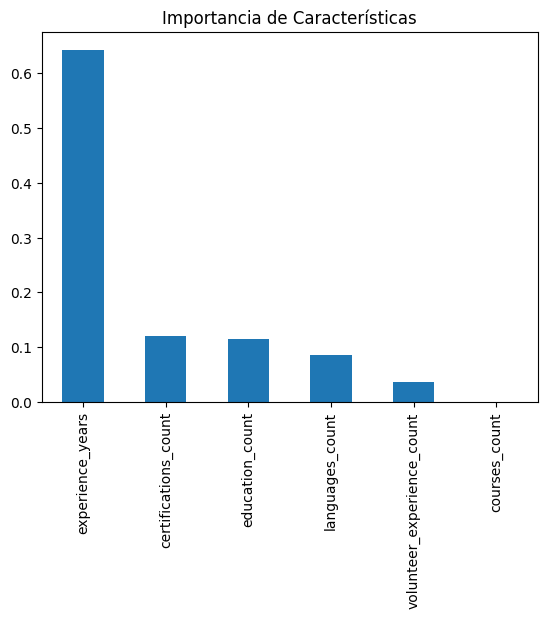

Importancias de características guardadas en './data/feature_importances.csv'


In [25]:
# Entrenar el modelo de Random Forest optimizado para calcular la importancia de las características con datos resampleados
optimized_rf_model.fit(X_train_resampled, y_train_resampled)

# Extraer la importancia de las características
feature_importances = pd.Series(optimized_rf_model.feature_importances_, index=features)

# Ordenar las importancias en orden descendente
feature_importances_sorted = feature_importances.sort_values(ascending=False)

# Visualizar las importancias
feature_importances_sorted.plot(kind='bar', title='Importancia de Características')
plt.show()

# Guardar las importancias en un archivo CSV para usar en la aplicación Streamlit
feature_importances_df = pd.DataFrame({
    'feature': feature_importances_sorted.index,
    'importance': feature_importances_sorted.values
})

# Guarda el DataFrame de importancias en un CSV
feature_importances_df.to_csv('./../data/feature_importances.csv', index=False)

print("Importancias de características guardadas en './data/feature_importances.csv'")

# Seleccionar las características más importantes (por encima de un umbral)
important_features = feature_importances[feature_importances > 0.05].index.tolist()
X_train_important = X_train[important_features]
X_test_important = X_test[important_features]

Predicción de candidatos potenciales con random forest optimizado

In [27]:
# Filtrar perfiles sin empleo
unemployed_profiles_optimized = df[df['employed'] == 0].copy()  # Filtra los perfiles que no están actualmente empleados

# Seleccionar las características importantes utilizadas en el entrenamiento
unemployed_features_optimized = unemployed_profiles_optimized[features].fillna(0)

# Escalar las características de los perfiles sin empleo usando el mismo escalador
unemployed_features_scaled_optimized = scaler.transform(unemployed_features_optimized)

# Predecir probabilidades de empleo con el modelo optimizado de Random Forest
y_probs_unemployed_optimized = optimized_rf_model.predict_proba(unemployed_features_scaled_optimized)[:, 1]

final_threshold = 0.4125  # Ajusta este umbral según el F1-Score óptimo obtenido
# Aplicar el umbral final para considerar a alguien como candidato potencial
unemployed_profiles_optimized['predicted_employed'] = (y_probs_unemployed_optimized >= final_threshold).astype(int)

# Filtrar los perfiles que son candidatos potenciales
potential_candidates_optimized_rf = unemployed_profiles_optimized[unemployed_profiles_optimized['predicted_employed'] == 1]

# Guardar los candidatos potenciales en un archivo CSV
potential_candidates_optimized_rf.to_csv('./../data/potential_candidates_optimized_rf.csv', index=False)

print("Candidatos potenciales guardados en './data/potential_candidates_optimized_rf.csv'")

Candidatos potenciales guardados en './data/potential_candidates_optimized_rf.csv'


Opcional: Optimización con ensemble stacking

[LightGBM] [Info] Number of positive: 572, number of negative: 572
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000088 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 183
[LightGBM] [Info] Number of data points in the train set: 1144, number of used features: 5
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.400000 -> initscore=-0.405465
[LightGBM] [Info] Start training from score -0.405465
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf

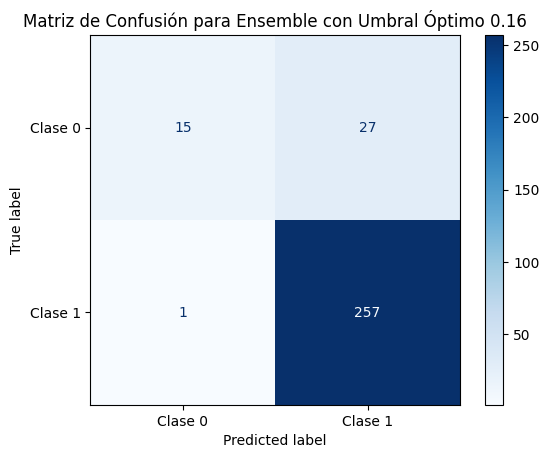

In [28]:
from sklearn.ensemble import StackingClassifier
from sklearn.linear_model import LogisticRegression
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
from sklearn.metrics import precision_recall_curve, classification_report, confusion_matrix, ConfusionMatrixDisplay
from imblearn.over_sampling import SMOTE
import numpy as np
import matplotlib.pyplot as plt

# Definir SMOTE para balancear las clases en el conjunto de entrenamiento
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train_scaled, y_train)

# Definir un ensemble stacking con tres modelos optimizados y ajuste moderado de class_weight
estimators = [
    ('rf', RandomForestClassifier(**random_search_rf.best_params_, class_weight={0: 1.5, 1: 1}, random_state=42)),
    ('xgb', XGBClassifier(**grid_search_xgb.best_params_)),  # No añadir random_state aquí
    ('lgbm', LGBMClassifier(class_weight={0: 1.5, 1: 1}, random_state=42))
]

stacking_model = StackingClassifier(
    estimators=estimators,
    final_estimator=LogisticRegression(),
    cv=5,
)

# Entrenar el ensemble con los datos resampleados
stacking_model.fit(X_train_resampled, y_train_resampled)

# Predecir probabilidades en el conjunto de prueba con el ensemble
y_probs_stacking = stacking_model.predict_proba(X_test_scaled)[:, 1]

# Calcular la curva de precisión-recall para encontrar el umbral óptimo
precision, recall, thresholds = precision_recall_curve(y_test, y_probs_stacking)

# Calcular F1-Score de forma más robusta
f1_scores = np.where(precision + recall > 0, 2 * (precision * recall) / (precision + recall), 0)

# Encontrar el umbral óptimo para maximizar el F1-Score
optimal_threshold = thresholds[f1_scores.argmax()]
print(f"Umbral óptimo basado en el F1-Score para el ensemble: {optimal_threshold}")

# Usar el umbral óptimo para hacer predicciones
y_pred_optimal = (y_probs_stacking >= optimal_threshold).astype(int)

# Reporte de clasificación y matriz de confusión con el umbral óptimo
report = classification_report(y_test, y_pred_optimal, target_names=['Clase 0', 'Clase 1'], digits=4)
print(f"Classification Report con umbral óptimo {optimal_threshold:.2f}:\n", report)

# Mostrar la matriz de confusión con el umbral óptimo
cm = confusion_matrix(y_test, y_pred_optimal)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Clase 0', 'Clase 1'])
disp.plot(cmap=plt.cm.Blues)
plt.title(f"Matriz de Confusión para Ensemble con Umbral Óptimo {optimal_threshold:.2f}")
plt.show()

Predicción de potenciales candidatos con el modelo ensemble optimizado

In [29]:
from sklearn.preprocessing import StandardScaler

# Asegúrate de usar todas las características que el modelo espera (todas las usadas en el entrenamiento)
# Si 'features' es la lista original usada para entrenar
all_features = features  # Verifica que 'features' sea el conjunto usado para entrenar

# Filtrar perfiles sin empleo
unemployed_profiles = df[df['employed'] == 0].copy()  # Filtra los perfiles que no están actualmente empleados

# Seleccionar todas las características utilizadas en el entrenamiento
unemployed_features = unemployed_profiles[all_features].fillna(0)

# Reajustar el escalador con las características correctas, si el problema persiste
scaler = StandardScaler()
scaler.fit(X_train[all_features])  # Ajustar el escalador con el conjunto de entrenamiento

# Escalar las características de los perfiles sin empleo usando el mismo escalador
unemployed_features_scaled = scaler.transform(unemployed_features)

# Predecir candidatos potenciales con el modelo de RandomForest optimizado
# Aplicar el umbral final para considerar a alguien como candidato potencial
final_threshold = 0.4125  # Ajusta este umbral según el F1-Score óptimo obtenido

# Predecir las probabilidades de los perfiles sin empleo
y_probs_unemployed = optimized_rf_model.predict_proba(unemployed_features_scaled)[:, 1]

# Predecir los candidatos potenciales aplicando el umbral
unemployed_profiles['predicted_employed'] = (y_probs_unemployed >= final_threshold).astype(int)

# Filtrar los perfiles que son candidatos potenciales
potential_candidates_optimized = unemployed_profiles[unemployed_profiles['predicted_employed'] == 1]

# Guardar los candidatos potenciales en un archivo CSV
try:
    potential_candidates_optimized.to_csv('./../data/potential_candidates_optimized_ensemble.csv', index=False)
    print("Candidatos potenciales guardados en './../data/potential_candidates_optimized_ensemble.csv'")
except Exception as e:
    print("Error al guardar el archivo CSV:", e)
    raise

Candidatos potenciales guardados en './../data/potential_candidates_optimized_ensemble.csv'


Implementación con SMOTE-Tomek y Gradient Boosting:

Fitting 5 folds for each of 81 candidates, totalling 405 fits
Mejores parámetros para Gradient Boosting: {'learning_rate': 0.2, 'max_depth': 3, 'n_estimators': 200, 'subsample': 0.7}
Umbral óptimo basado en el F1-Score para Gradient Boosting: 0.26557040758405576
Classification Report Gradient Boosting con umbral óptimo 0.27:
               precision    recall  f1-score   support

     Clase 0     0.9444    0.4048    0.5667        42
     Clase 1     0.9113    0.9961    0.9519       258

    accuracy                         0.9133       300
   macro avg     0.9279    0.7004    0.7593       300
weighted avg     0.9160    0.9133    0.8979       300



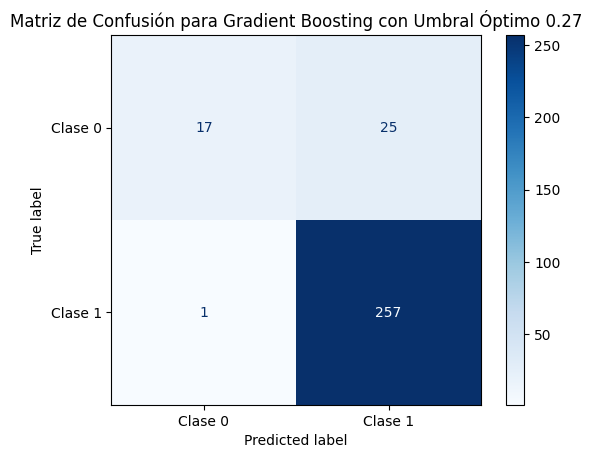

In [43]:
from imblearn.combine import SMOTETomek
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import classification_report, precision_recall_curve, confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
import numpy as np
import matplotlib.pyplot as plt

# Aplicar SMOTE-Tomek para balancear las clases en el conjunto de entrenamiento
smote_tomek = SMOTETomek(random_state=42)
X_train_resampled, y_train_resampled = smote_tomek.fit_resample(X_train_scaled, y_train)

# Configurar los parámetros para Gradient Boosting
param_grid_gb = {
    'n_estimators': [100, 200, 300],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.05, 0.1, 0.2],
    'subsample': [0.7, 0.8, 1.0]
}

# Configurar GridSearchCV para encontrar los mejores parámetros
grid_search_gb = GridSearchCV(
    estimator=GradientBoostingClassifier(random_state=42),
    param_grid=param_grid_gb,
    scoring='f1_weighted',
    cv=5,
    verbose=1,
    n_jobs=-1
)

# Ejecutar Grid Search para encontrar los mejores parámetros
grid_search_gb.fit(X_train_resampled, y_train_resampled)
print(f"Mejores parámetros para Gradient Boosting: {grid_search_gb.best_params_}")

# Entrenar el modelo Gradient Boosting con los mejores hiperparámetros
gb_model = GradientBoostingClassifier(**grid_search_gb.best_params_, random_state=42)
gb_model.fit(X_train_resampled, y_train_resampled)

# Predecir probabilidades en el conjunto de prueba
y_probs_gb = gb_model.predict_proba(X_test_scaled)[:, 1]

# Calcular la curva de precisión-recall para encontrar el umbral óptimo
precision, recall, thresholds = precision_recall_curve(y_test, y_probs_gb)

# Calcular F1-Score para determinar el umbral óptimo
f1_scores = np.where(precision + recall > 0, 2 * (precision * recall) / (precision + recall), 0)
optimal_threshold = thresholds[f1_scores.argmax()]
print(f"Umbral óptimo basado en el F1-Score para Gradient Boosting: {optimal_threshold}")

# Usar el umbral óptimo para hacer predicciones
y_pred_optimal = (y_probs_gb >= optimal_threshold).astype(int)

# Reporte de clasificación y matriz de confusión con el umbral óptimo
report = classification_report(y_test, y_pred_optimal, target_names=['Clase 0', 'Clase 1'], digits=4)
print(f"Classification Report Gradient Boosting con umbral óptimo {optimal_threshold:.2f}:\n", report)

# Mostrar la matriz de confusión con el umbral óptimo
cm = confusion_matrix(y_test, y_pred_optimal)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Clase 0', 'Clase 1'])
disp.plot(cmap=plt.cm.Blues)
plt.title(f"Matriz de Confusión para Gradient Boosting con Umbral Óptimo {optimal_threshold:.2f}")
plt.show()